In [3]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_L99(y,utilde,plotOpt=False):
    utop = 0.99*inp.du/2
    ubot = -0.99*inp.du/2
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    L99 = y[itop]-y[ibot]
    if plotOpt:
        plt.plot(y,utilde)
        #plt.plot(y[:Ny/2],utilde[:Ny/2],'--')
        #plt.plot(y[Ny/2:],utilde[Ny/2:],'--')
        plt.plot([y[ibot],y[ibot]],[-inp.du/2.,inp.du/2.],'k:',label='bot')
        plt.plot([y[itop],y[itop]],[-inp.du/2.,inp.du/2.],'k--',label='top')
        plt.legend()
    return L99,itop,ibot

def integrate_y(y,f,method='midpoint'):
    ny = np.size(y)
    dy = abs(y[0]-y[1])
    I = 0.
    
    if method=='midpoint':
        for i in range(ny-1):
            I += dy*0.5*(f[i]+f[i+1])
            
    elif method=='simpsons':
        for i in range(ny-2):
            if i%2==0: I += dy/3.*(f[i]+4*f[i+1]+f[i+2])
                
    elif method=='trapz':
        for i in range(ny-1):
            I += dy*0.5*(f[i]+f[i+1])
            
    else: print('Invalid integration method {}'.format(method))
    return I

def window_tukey(n,N,alpha=0.5):
    tmp = alpha*N/2
    pi = np.pi

    if n<tmp:
        return 0.5*(1.+np.cos(pi*(n/tmp-1.)))
    elif n>=tmp and n<N*(1.-alpha/2.):
        return 1.
    elif n>=N*(1.-alpha/2.) and n<=N:
        return 0.5*(1.+np.cos(pi*(n/tmp-2./alpha+1.)))
    else:
        return 0

def window_field(filename_prefix,ychunk,yplot,du,tID,q,utilde=None,pad=0):
    if utilde is None:
        fname = filename_prefix+'utilde_%04d.dat'%tID
        try:
            utilde = np.fromfile(fname,count=-1,sep=' ')
        except:
            print('Write {}'.format(fname))
            sys.exit()
    L99, itop, ibot = get_L99(yplot,utilde)
    #print(L99, itop,ibot,y[itop],y[ibot])
    Ny = np.size(utilde)

    # Window based off 99% thickness
    ibot = max(ibot-pad,0)
    itop = min(itop+pad,Ny)
    N = abs(itop-ibot)      # total window size
    ny = np.shape(q)[1]     # size of chunk
    for iy_,ylocal in zip(range(ny),ychunk[0,:,0]):
        if ylocal>yplot[ibot] and ylocal<yplot[itop]:
            iy = np.argmin(abs(ylocal-yplot)) #global y index
            idx = iy-ibot # distance from bottom bound
            
            assert idx>=0
            assert idx<=N
            q[:,iy_,:] *= window_tukey(idx,N)
        else:
            q[:,iy_,:] = 0
    return q

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Mt*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_Mt_0001.dat', 'shearlayer_Mt_0002.dat', 'shearlayer_Mt_0003.dat', 'shearlayer_Mt_0004.dat', 'shearlayer_Mt_0005.dat', 'shearlayer_Mt_0006.dat', 'shearlayer_Mt_0007.dat', 'shearlayer_Mt_0008.dat', 'shearlayer_Mt_0009.dat', 'shearlayer_Mt_0010.dat', 'shearlayer_Mt_0011.dat', 'shearlayer_Mt_0012.dat', 'shearlayer_Mt_0013.dat']


16.033172080165862


Text(0.5,0,'y')

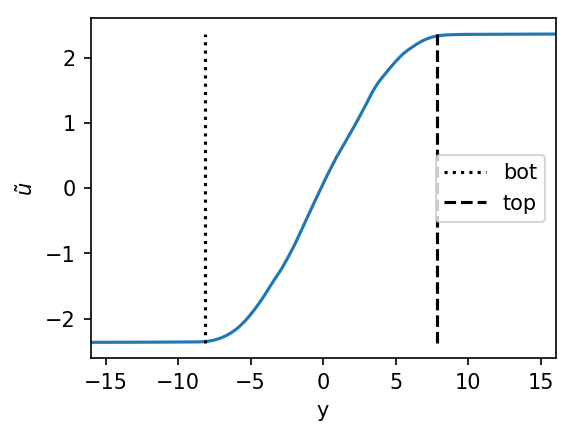

In [2]:

fig = plt.figure(figsize=(4,3),dpi=150)
tmp = glob.glob(directory+"*utilde*")
utilde=np.fromfile(tmp[-1],sep=' ')  
L99,i1,i2=get_L99(y,utilde,plotOpt=True) #itop,ibot
print(L99)


plt.xlim([-L99,L99])
plt.ylabel(r'$\tilde{u}$')
plt.xlabel('y')
# window_tukey(n,N,alpha=0.5):

(2.0, 1.0)


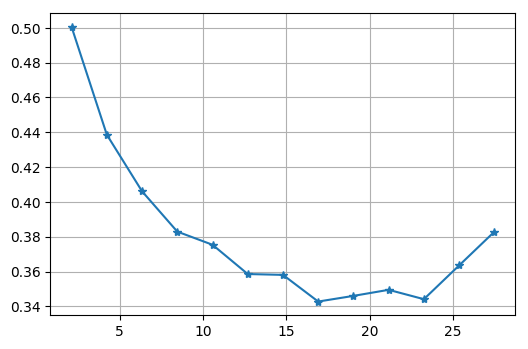

In [5]:
# Integrated profiles
# 1D integration in y using midpoint rule:

def get_Mt(directory,flist):
    mat = np.zeros([len(flist),3])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta

        # Get centerline
        ic,yc = get_centerline(directory,-y,tID)

        # Get turb Mach
        Mt = np.fromfile(fname,dtype=float, count=-1, sep=' ')
        
        # Get cbar and nominal factor
        cbar = np.fromfile(directory+'shearlayer_cbar_%04d'%(tID)+'.dat', sep=' ')
        cbar_used = np.amax(cbar)
        cbar_factor = cbar_used/np.sqrt(1.4)

        # Record for later
        mat[i,0] = time
        mat[i,1] = max(Mt)
        mat[i,2] = max(Mt)*cbar_factor
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]


fig = plt.figure(dpi=100)
dat = get_Mt(directory,flist[:])
plt.grid(True)
# plt.xlim([-20,20])
plt.plot(dat[:,0]/inp.du,dat[:,1],'-*')
print(inp.Mc,inp.rr)

0.2:[0.0732778079541,0.000928369759584],
0.8:[0.23573697572,0.00313157096841],
1.2:[0.320183269301,0.00557431563276],
1.6:[0.377787374587,0.00139549212637],
2.0:[0.429843378367,0.0165583692697],
Done


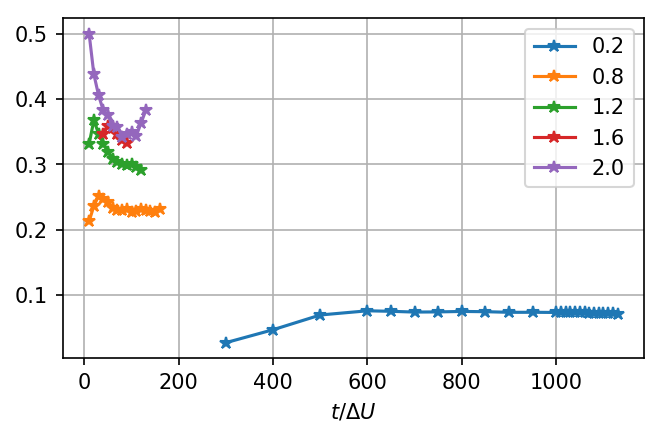

In [10]:
s = '1'

if s=='1': Mc_list = ['02','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*Mt*")
    flist.sort()

    # Plot Rij
    dat = get_Mt(directory,flist)
    t = dat[:,0]
    f = dat[:,2]
    ax.plot(t,dat[:,1],'-*',label='{}'.format(inp.Mc))
    
    idx = 4
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')
# ax.set_xlim([-20,900])
# ax[0].set_xlim([0,200])
plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/'+'Mt_s%s'%s,dpi=200,bbox_inches='tight')

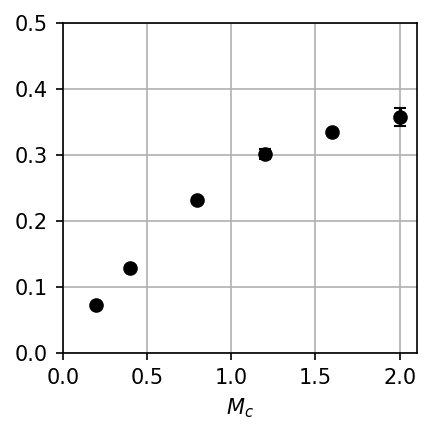

In [13]:
Mt_s7 = {
0.2:[0.0766310556586,0.000475381379865],
0.8:[0.236897112133,0.0125735989276],
2.0:[0.390936646086,0.0203210448896],
}
Mt_s_7 = {
0.2:[0.0963192542581,0.00205533467737],
0.8:[0.336497481972,0.00259834163922],
2.0:[0.524738813778,0.0315340758122],
}
Mt = {
0.2:[0.0731671350786,0.000940706729493],
0.4:[0.129966376118,0.00147112408558],
0.8:[0.231636974128,0.00432740283333],
1.2:[0.30218202116,0.00790590335407],
1.6:[0.334919156671,0.00226438808891],
2.0:[0.35788829592,0.0132951241826],
}

def plotter(dat,label,fmt,fillstyle='full'):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,label=label,capsize=3,fillstyle=fillstyle)

fig = plt.figure(figsize=(3,3),dpi=150)
s1 = Mt
s7 = Mt_s7#merge_dicts(Mt_s7,Mt_s_7)
plotter(s1,'s=1','ko')
# plotter(s7,'s=7','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$M_{t}$')
# plt.legend(fontsize=8)
plt.xlim([0,2.1])
plt.ylim([0.0,0.5])
plt.tight_layout()
plt.savefig('/home/kmatsuno/ShearLayer_img/Mt.png',dpi=200, bbox_inches='tight')

Text(0,0.5,'$M_y$')

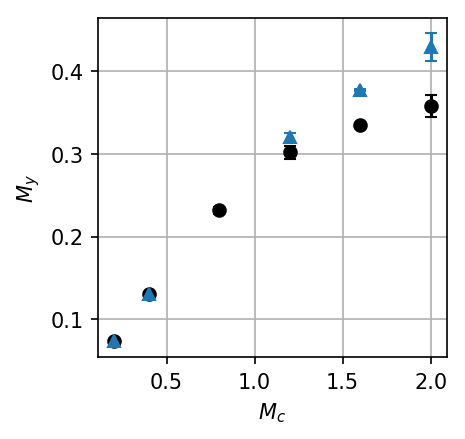

In [14]:
# Mt using nominal cbar:
Mt_c0 = {
0.2:[0.0731671350786,0.000940706729493],
0.4:[0.129966376118,0.00147112408558],
1.2:[0.320183269301,0.00557431563276],
1.6:[0.377787374587,0.00139549212637],
2.0:[0.429843378367,0.0165583692697],
}

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(Mt,'','ko')
plotter(Mt_c0,'','^')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$M_y$')
